In [29]:

import pandas as pd
import numpy as np
import re
import nltk

In [30]:
import wikipediaapi
from nltk.tokenize import sent_tokenize

In [31]:
wiki_wiki = wikipediaapi.Wikipedia('en')

wiki_py = wiki_wiki.page("Pac-Man")

corpus_txt = ""
nr_used_sections = 0

def get_sections(sections, level=0):
    global nr_used_sections
    global corpus_txt
    for s in sections:
        if "references" not in s.title.lower() and "links" not in s.title.lower() and "further" not in s.title.lower() and "notes" not in s.title.lower():
            # keep meaningful characters for topic sentences to be printed..
            txt = re.sub(r"""[^a-zA-Z0-9.,;:!?\s'"-]""", '', s.text)
            txt = re.sub(r'\s+', ' ', txt)
            corpus_txt += txt
            nr_used_sections += 1
        get_sections(s.sections, level + 1)

get_sections(wiki_py.sections)


In [32]:
# check if corpus_data folder exists, if not, create it
import os
folder = "./corpus_data/"
if not os.path.exists(folder):
    os.makedirs(folder)

# check if corpus_data folder is empty, if not, create the corpus data files
if len(os.listdir(folder)) == 0:
    for i, sent in enumerate(sent_tokenize(corpus_txt)):
        with open(folder+f'pacman_{i+1}.txt', 'w', encoding="utf-8") as f:
            f.write(sent)

In [33]:
nr_used_sections

18

In [34]:
ts = 2  # the number of topics to start with 2
te = nr_used_sections * 2 + 1 # maximum number of topics to end with

In [35]:
import tmtoolkit
from tmtoolkit.corpus import filter_for_pos
from tmtoolkit.corpus import dtm
from tmtoolkit.corpus import Corpus, print_summary

In [36]:
from copy import copy
corpus = Corpus.from_folder(folder, language='en')
crp = copy(corpus)
print_summary(crp)

Corpus with 203 documents in English
> pacman_105 (32 tokens): II Computing also listed the Atarisoft port tenth ...
> pacman_102 (55 tokens): Pac - Man is the best - selling arcade game of all...
> pacman_106 (43 tokens): As of 2016 , all versions of Pac - Man are estimat...
> pacman_104 (124 tokens): In addition , Coleco 's tabletop mini - arcade uni...
> pacman_103 (52 tokens): Pac - Man and Ms. Pac - Man also topped the US ReP...
> pacman_100 (59 tokens): Among the nine arcade games covered by How to Win ...
> pacman_1 (22 tokens): Pac - Man is an action maze chase video game ; the...
> pacman_10 (43 tokens): Pac - Man can eat blue ghosts for bonus points ; w...
> pacman_101 (30 tokens): In a 1983 interview , Nakamura said that though he...
> pacman_107 (17 tokens): Pac - Man also won the Video Software Dealers Asso...
(and 193 more documents)
total number of tokens: 7096 / vocabulary size: 1829


In [37]:
from tmtoolkit.corpus import lemmatize, to_lowercase, remove_punctuation, filter_clean_tokens

In [38]:
filter_clean_tokens(crp, remove_shorter_than=2, remove_numbers=True, remove_punct=True, remove_stopwords=True)
to_lowercase(crp)

print_summary(crp)

Corpus with 203 documents in English
> pacman_105 (16 tokens): ii computing listed atarisoft port magazine list a...
> pacman_102 (20 tokens): pac man best selling arcade game time surpassing s...
> pacman_106 (16 tokens): versions pac man estimated grossed total revenue p...
> pacman_104 (58 tokens): addition coleco tabletop mini arcade unit sold uni...
> pacman_103 (25 tokens): pac man ms. pac man topped replay cocktail arcade ...
> pacman_100 (21 tokens): arcade games covered win video games pac man femal...
> pacman_1 (13 tokens): pac man action maze chase video game player contro...
> pacman_10 (19 tokens): pac man eat blue ghosts bonus points ghost eaten e...
> pacman_101 (9 tokens): interview nakamura said expect pac man successful ...
> pacman_107 (11 tokens): pac man won video software dealers association vsd...
(and 193 more documents)
total number of tokens: 3247 / vocabulary size: 1401


In [39]:
dtm_, doc_labels, vocab = dtm(crp, return_doc_labels=True, return_vocab=True)

In [40]:
top_n = int(0.01 * dtm_.shape[1])
top_n

14

In [41]:
%%time
import tmtoolkit
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

const_params = {
    'n_iter': 100,
    'random_state': 42,  # to make results reproducible
    'eta': 0.1,                # sometimes also called "beta"
}

# iterate with different LDA models with different number of topics
var_params = [{'n_topics': k, 'alpha': 1.0/k}
               for k in range(ts, te, 1)]

eval_results = evaluate_topic_models(dtm_,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     coherence_mimno_2011_top_n=top_n,
                                     coherence_mimno_2011_include_prob=True,
                                     return_models=False)

Wall time: 17.1 s


In [42]:
# get the best model according to Cao & Juan (2009)
results = []
for k, res in eval_results:
    results.append((k, res))

mimno_scores = [res['coherence_mimno_2011'] for k, res in results]
best_mimno_k = results[np.argmax(mimno_scores)][0]
best_mimno_k

{'n_topics': 36,
 'alpha': 0.027777777777777776,
 'n_iter': 100,
 'random_state': 42,
 'eta': 0.1}

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [44]:
# compare k and coherence score
k = [k[0]["n_topics"] for k in results]
coh_m = [k[1]["coherence_mimno_2011"] for k in results]
best_mimno_k = results[np.argmax(coh_m)][0]["n_topics"]
df_mimno_k = pd.DataFrame({"k": k, "coherence_mimno_2011": coh_m})

In [45]:
scores = [k[1]["cao_juan_2009"] for k in results]
best_cao_k = results[np.argmin(scores)][0]["n_topics"]
df_cao_k = pd.DataFrame({"k": k, "cao_juan_2009": scores})

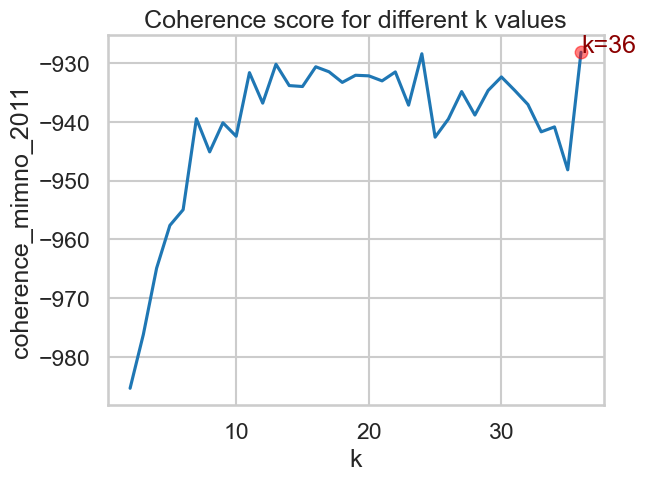

In [46]:
sns.lineplot(x="k", y="coherence_mimno_2011", data=df_mimno_k)
plt.title("Coherence score for different k values")
# mark the best k with red dot
plt.plot(best_mimno_k, df_mimno_k[df_mimno_k["k"] == best_mimno_k]["coherence_mimno_2011"], "ro", alpha=0.5)
# write the best k value
plt.text(best_mimno_k, df_mimno_k[df_mimno_k["k"] == best_mimno_k]["coherence_mimno_2011"] + 0.01, f"k={best_mimno_k}", color="darkred")
plt.show()

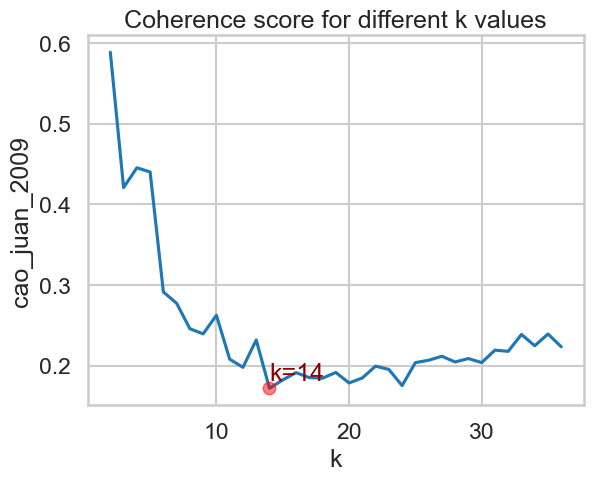

In [47]:
sns.lineplot(x="k", y="cao_juan_2009", data=df_cao_k)
plt.title("Coherence score for different k values")
# mark the best k with red dot
plt.plot(best_cao_k, df_cao_k[df_cao_k["k"] == best_cao_k]["cao_juan_2009"], "ro", alpha=0.5)
# write the best k value
plt.text(best_cao_k, df_cao_k[df_cao_k["k"] == best_cao_k]["cao_juan_2009"] + 0.01, f"k={best_cao_k}", color="darkred")
plt.show()